In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import umap
import keras
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from random import randrange
from keras import layers, regularizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

The models in this script are implemented using the "functional" API of Keras (as opposed to its "sequencial" API, [their differences](https://stackoverflow.com/a/58092554/947889)). 

Interesting blog posts:
- https://keras.io/examples/generative/vae/
- https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
- http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
- https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/
- https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
- https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
- https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df

Overview: 

1. Load data; 
2. Split into dev, train, and eval sets;
3. normalize sets separately;

# Load, Normalize, and Split Data

Should data be normalized before or after they're split (see [this](https://datascience.stackexchange.com/a/27616/106388) and [this](https://stats.stackexchange.com/a/375183/269404)). We had a chat and agreed on normalizing data after the split.

In [40]:
def get_data():
    # Load Data
    # We load data into RAM since data is small and will fit in memory.
    cells = pd.read_csv("../data/HTA9-3_Bx1_HMS_Tumor_quant.csv", header=0)
    
    # Keeps only the 'interesting' columns.
    cells = cells.filter(regex="nucleiMasks$", axis=1).filter(regex="^(?!(DAPI|AF))", axis=1)
    markers = cells.columns
    markers = [re.sub("\_nucleiMasks", "", x) for x in markers]
    
    return cells, markers

inputs, markers = get_data()
inputs.head()

,ERK1_1_nucleiMasks,ERK1_2_nucleiMasks,RAD51_nucleiMasks,Cyc_D1_nucleiMasks,Vimentin_nucleiMasks,aSMA_nucleiMasks,E_cadherin_nucleiMasks,ER_alpha_nucleiMasks,PR_nucleiMasks,EGFR_nucleiMasks,...,CD45_nucleiMasks,Ki67_nucleiMasks,CK19_nucleiMasks,p21_nucleiMasks,CK14_nucleiMasks,AR_nucleiMasks,cPARP_nucleiMasks,CK17_nucleiMasks,CK7_nucleiMasks,HER2_nucleiMasks
0,5450.053097,2984.433628,14367.628319,4903.380531,403.230088,653.628319,1090.991150,615.955752,97.407080,1603.814159,...,1454.955752,547.088496,9.566372,221.628319,1602.982301,398.088496,1296.256637,1417.610619,111.592920,1518.964602
1,5387.080645,2849.209677,14496.790323,5259.145161,493.967742,652.580645,11086.564516,2176.935484,311.435484,2721.000000,...,2111.177419,1404.741935,27.096774,563.419355,2225.564516,560.048387,1810.629032,2342.016129,179.387097,2542.080645
2,8060.108844,4101.156463,16948.945578,6473.231293,512.221088,765.217687,11262.397959,2669.503401,395.982993,2158.693878,...,2019.445578,1451.850340,27.819728,581.363946,2237.112245,558.353741,1804.704082,2360.625850,183.289116,2533.887755
3,4906.417476,2603.077670,13637.854369,4976.902913,471.854369,617.854369,13807.271845,2043.349515,338.582524,2374.757282,...,2062.058252,1447.067961,29.446602,576.864078,2254.446602,558.815534,1802.242718,2365.262136,182.951456,2536.514563
4,5008.510526,2614.742105,13177.589474,6494.763158,466.257895,660.184211,9432.521053,2070.726316,346.457895,2202.715789,...,2023.194737,1440.800000,29.457895,581.015789,2243.484211,567.031579,1812.384211,2365.152632,183.089474,2543.226316


In [41]:
def normalize(data):    
    # Input data contains some zeros which results in NaN (or Inf)
    # values when their log10 is computed. NaN (or Inf) are problematic
    # values for downstream analysis. Therefore, zeros are replaced by 
    # a small value; see the following thread for related discussion.
    # https://www.researchgate.net/post/Log_transformation_of_values_that_include_0_zero_for_statistical_analyses2
    data[data==0] = 1e-32
    data = np.log10(data)
    
    standard_scaler = StandardScaler()
    data = standard_scaler.fit_transform(data)
    data = data.clip(min=-10, max=10)
    
    # min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    # data = min_max_scaler.fit_transform(data)
    return data

inputs = np.array(inputs)
# random_state is a random seed to have a reproducible shuffling (only for dev purpose).
X_dev,   X_test  = train_test_split(inputs, test_size=0.05, random_state=1, shuffle=True)
X_train, X_val = train_test_split(X_dev,  test_size=0.25, random_state=1)

# This is primarily for the purpose of 
# being able to see how much data is removed
# (as part of outlier removal) and plot
# the changes in data distribution.
init_inputs = inputs
init_X_train = X_train
init_X_test = X_test
init_X_val = X_val

inputs = normalize(inputs)
X_train = normalize(X_train)
X_test = normalize(X_test)
X_val = normalize(X_val)

## Get an Overview of the Data

In [42]:
def get_percentage(new_num, org_num):
    return round((new_num * 100) / org_num, 2)


print(f"                    Input Shape:\t{init_inputs.shape}\t[{init_inputs.shape[0]}] Cells and [{init_inputs.shape[1]}] Markers\n")
print(f"Input size before normalization:\t{init_inputs.shape}")
print(f"Input size after  normalization:\t{inputs.shape}")
print(f"        Removed data percentage:\t{100 - get_percentage(inputs.shape[0], init_inputs.shape[0])}%")
print("")
print(f"                Train data size:\t{X_train.shape}\t({get_percentage(init_X_train.shape[0], init_inputs.shape[0])}% of input)")
print(f"                 Test data size:\t{X_test.shape}\t({get_percentage(init_X_test.shape[0], init_inputs.shape[0])}% of input)")
print(f"           Validation data size:\t{X_val.shape}\t({get_percentage(init_X_val.shape[0], init_inputs.shape[0])}% of input)")

# NOTE: the number of cells in X_train, X_test, and X_val would NOT
# add up to the number of cells in inputs if outliers are removed. 
# It is because outliers are removed after the cells in inputs 
# is split between train, test, and val sets.

                    Input Shape:	(40750, 21)	[40750] Cells and [21] Markers

Input size before normalization:	(40750, 21)
Input size after  normalization:	(40750, 21)
        Removed data percentage:	0.0%

                Train data size:	(29034, 21)	(71.25% of input)
                 Test data size:	(2038, 21)	(5.0% of input)
           Validation data size:	(9678, 21)	(23.75% of input)


## Some Checkes on the Normalized Data

In [43]:
rnd = randrange(0, inputs.shape[1])
# Mean should be zero and standard deviation 
# should be 1. However, due to some challenges 
# relationg to floating point positions and rounding, 
# the values should be very close to these numbers.
# For details, see:
# https://stackoverflow.com/a/40405912/947889
# Hence, we assert the rounded values.
print(inputs[:,rnd].std())
print(inputs[:,rnd].mean())

1.0
2.873556879834712e-16


## Plot Normalized Data Distributions

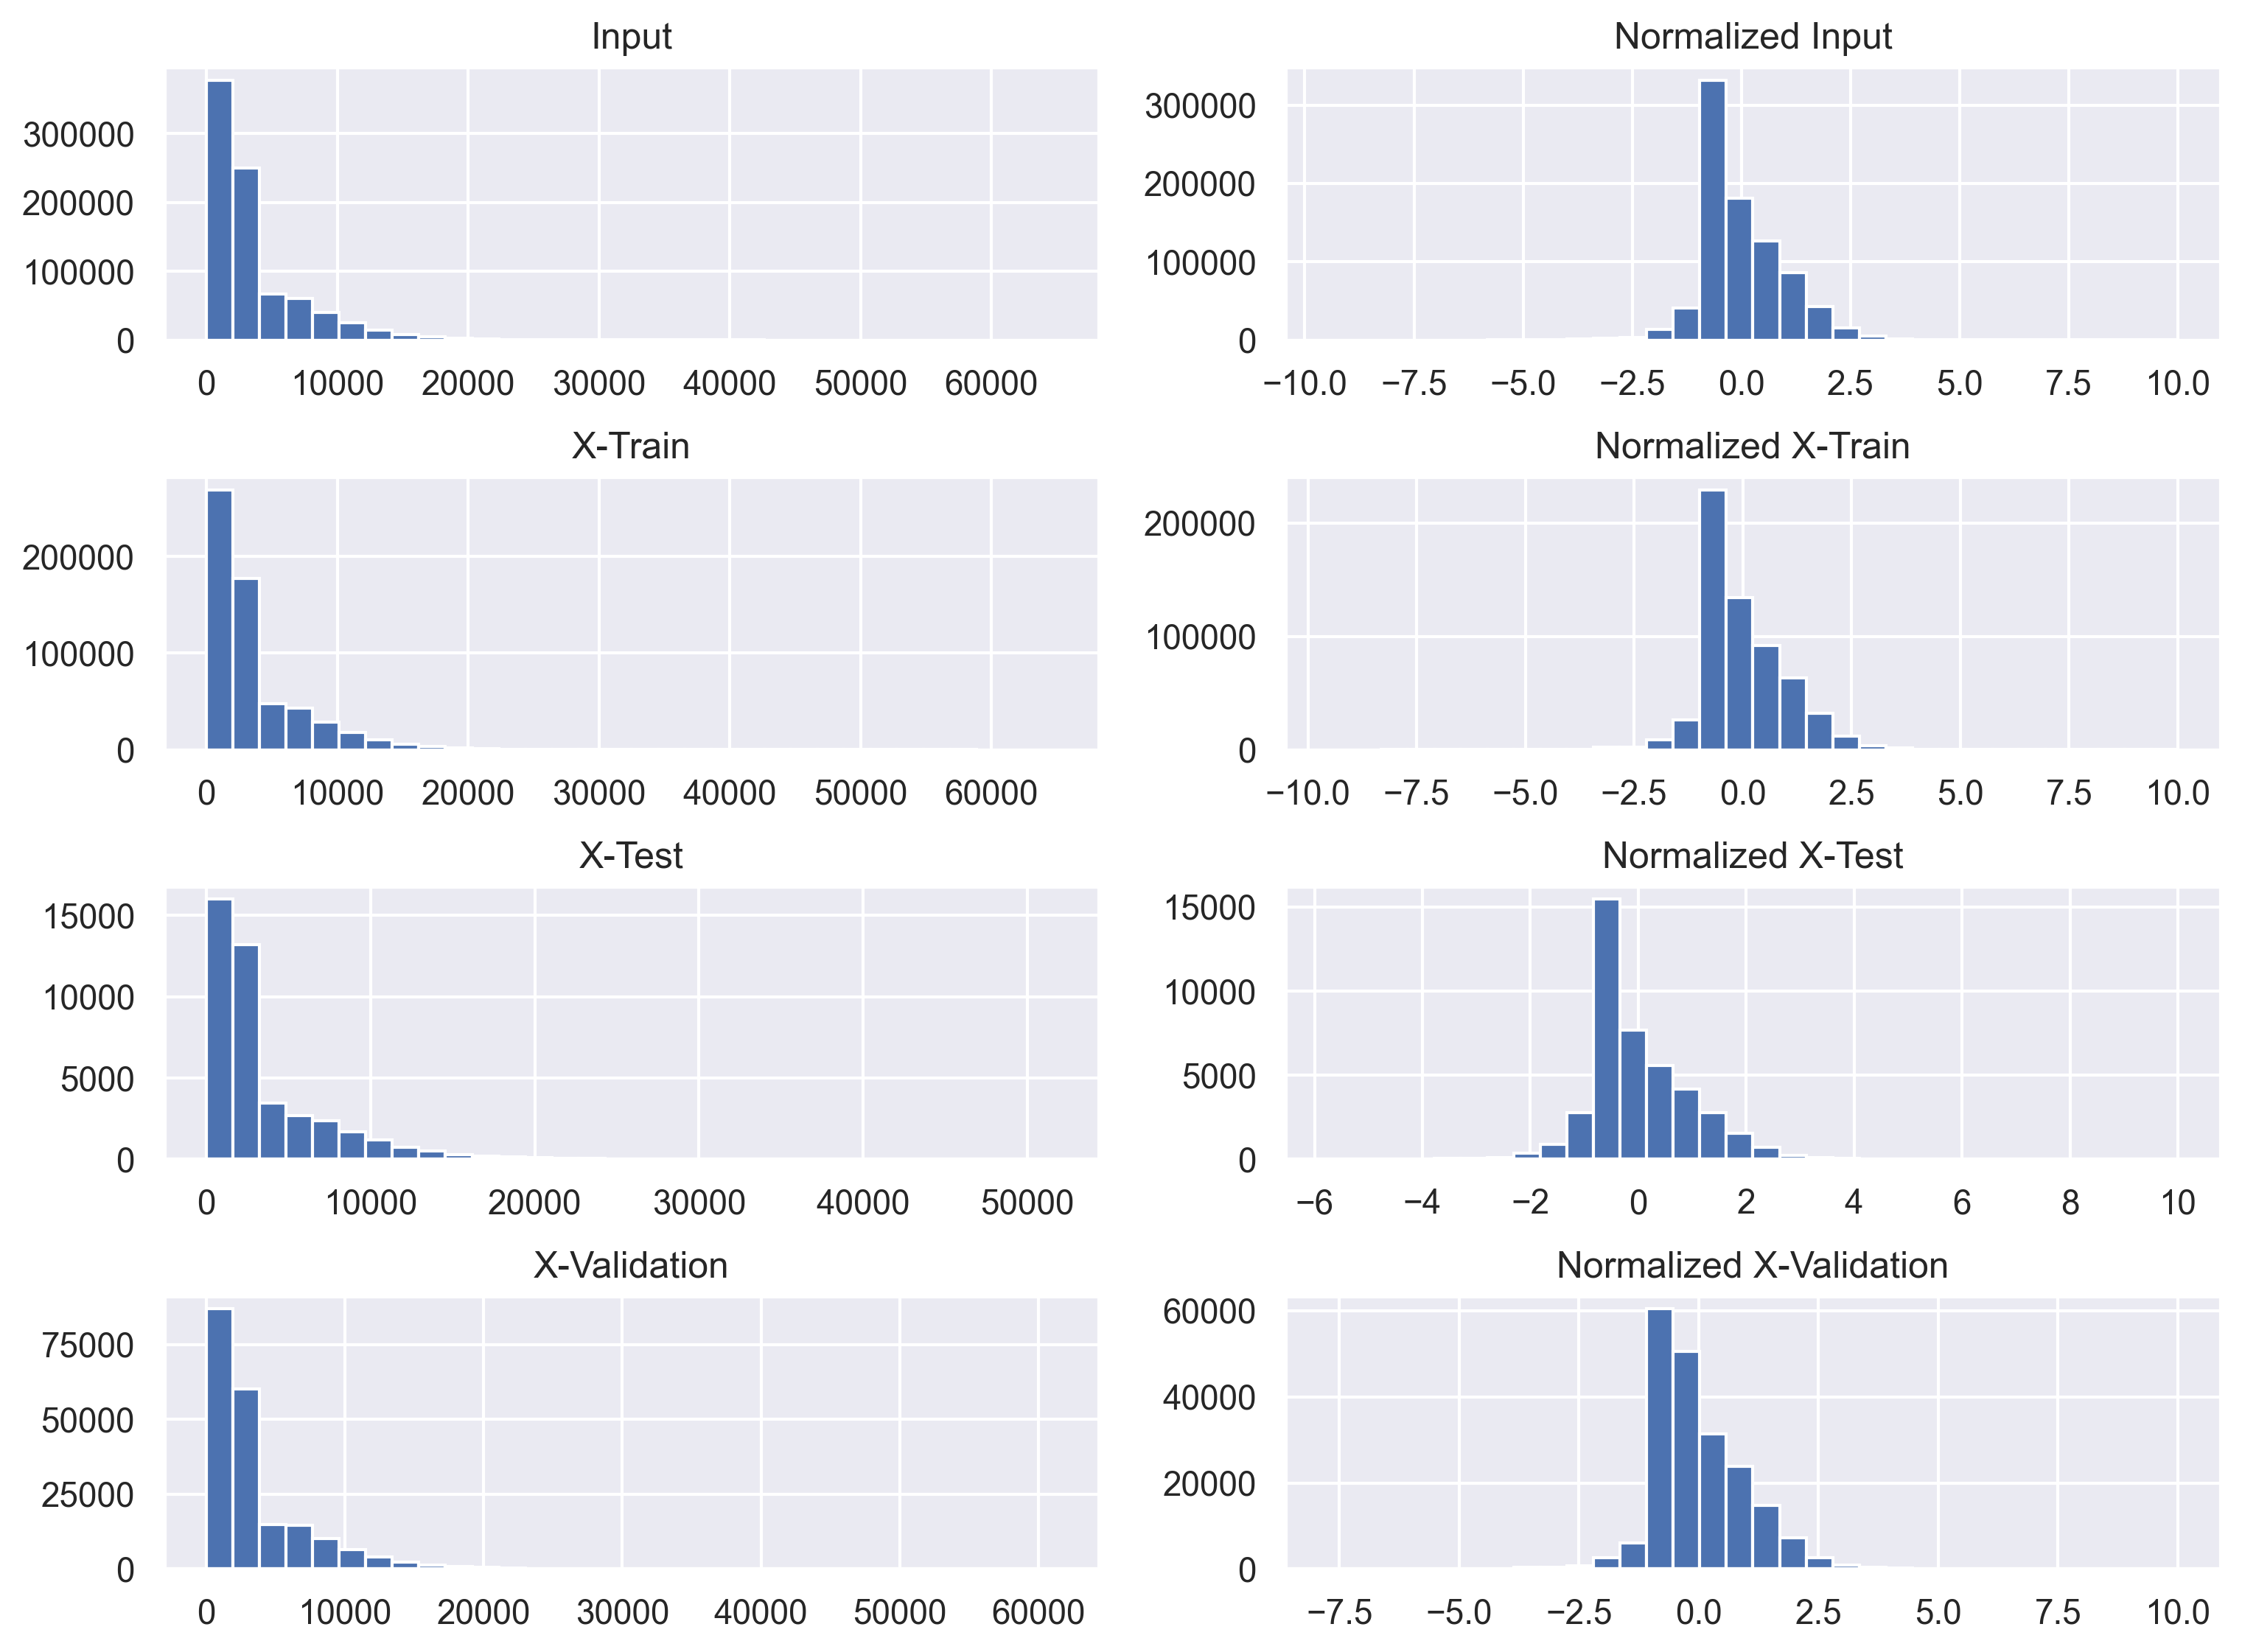

In [44]:
def plot_dists(ax, data, title, plot_type=""):
    # Flatten data, `ravel` yields a 1D "view",
    # which is more efficient than creating a 1D copy.
    f_data = data.ravel()
    
    if plot_type == "density":
        density = stats.gaussian_kde(f_data)
        n, x, _ = plt.hist(f_data, bins=25, histtype="step", density=True)
        ax.plot(x, density(x))
    elif plot_type == "both":
        density = stats.gaussian_kde(f_data)
        n, x, _ = ax.hist(f_data, bins=25, histtype="bar", density=True)
        ax.plot(x, density(x))
    else:
        ax.hist(f_data, bins=32, histtype="bar")
    ax.set_title(title)
    #ax.set_yscale('log')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 9), dpi=300)
plt.subplots_adjust(wspace=0.20, hspace=0.50)
plot_dists(axs[0, 0], init_inputs, "Input")
plot_dists(axs[0, 1], inputs, "Normalized Input")
plot_dists(axs[1, 0], init_X_train, "X-Train")
plot_dists(axs[1, 1], X_train, "Normalized X-Train")
plot_dists(axs[2, 0], init_X_test, "X-Test")
plot_dists(axs[2, 1], X_test, "Normalized X-Test")
plot_dists(axs[3, 0], init_X_val, "X-Validation")
plot_dists(axs[3, 1], X_val, "Normalized X-Validation")
plt.show()

# Define the Autoencoder
This implementation of autoencoer is based on the Kera documentation available at: https://keras.io/examples/generative/vae/

In [45]:
# Create sampling layer.
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a cell."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the encoder.

In [46]:
# length of latent vector.
latent_dim = 6

inputs_dim = inputs.shape[1]
r = regularizers.l1(10e-5)
activation = "linear"

encoder_inputs = keras.Input(shape=(inputs_dim))
h1 = layers.Dense(inputs_dim,     activation=activation, activity_regularizer=r)(encoder_inputs)
h2 = layers.Dense(inputs_dim / 2, activation=activation, activity_regularizer=r)(h1)
h3 = layers.Dense(inputs_dim / 3, activation=activation, activity_regularizer=r)(h2)

# The following variables are for the convenience of building the decoder.
# last layer before flatten
lbf = h3
# shape before flatten. 
sbf = keras.backend.int_shape(lbf)[1:]
# neurons count before latent dim
nbl = np.prod(sbf)


z_mean = layers.Dense(latent_dim, name="z_mean")(lbf)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(lbf)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 21)           462         input_5[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 10)           220         dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 7)            77          dense_13[0][0]                   
____________________________________________________________________________________________

## Build the Decoder

In [47]:
decoder_inputs = keras.Input(shape=(latent_dim,))
h1 = layers.Dense(nbl,            activation=activation)(decoder_inputs)
h2 = layers.Dense(inputs_dim / 2, activation=activation)(h1)

decoder_outputs = layers.Dense(inputs_dim)(h2)
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

# Visualize the model.
# tf.keras.utils.plot_model(model, to_file="model.png")

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 49        
_________________________________________________________________
dense_16 (Dense)             (None, 10)                80        
_________________________________________________________________
dense_17 (Dense)             (None, 21)                231       
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________


## Define VAE as a Model with a custom train_step

In [48]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss_fn = keras.losses.MeanSquaredError()
            reconstruction_loss = reconstruction_loss_fn(data, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        print (self.decoder(z))
        return self.decoder(z)

## Train the VAE

In [49]:
# Create the VAR, compile, and run.
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005))
history = vae.fit(X_train, validation_data=(X_val, X_val), epochs=100, batch_size=32, shuffle=True, verbose=0)

/Users/kirchgae/Development/OHSU/MarkerIntensityPredictor/venv/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Tensor("vae_2/decoder/dense_17/BiasAdd:0", shape=(None, 21), dtype=float32)


## Model Performance

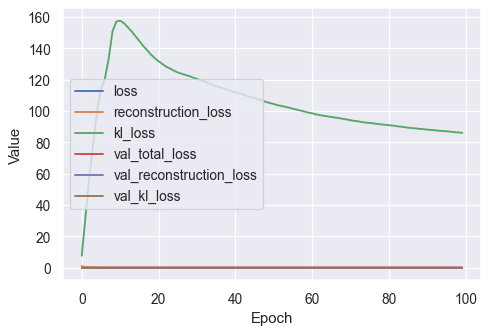

In [50]:
figure(num=None, figsize=(6, 4), dpi=90)
for key in history.history:
    plt.plot(history.history[key], label=key)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend() 
plt.show()

## Latent Space Clustering using UMAP

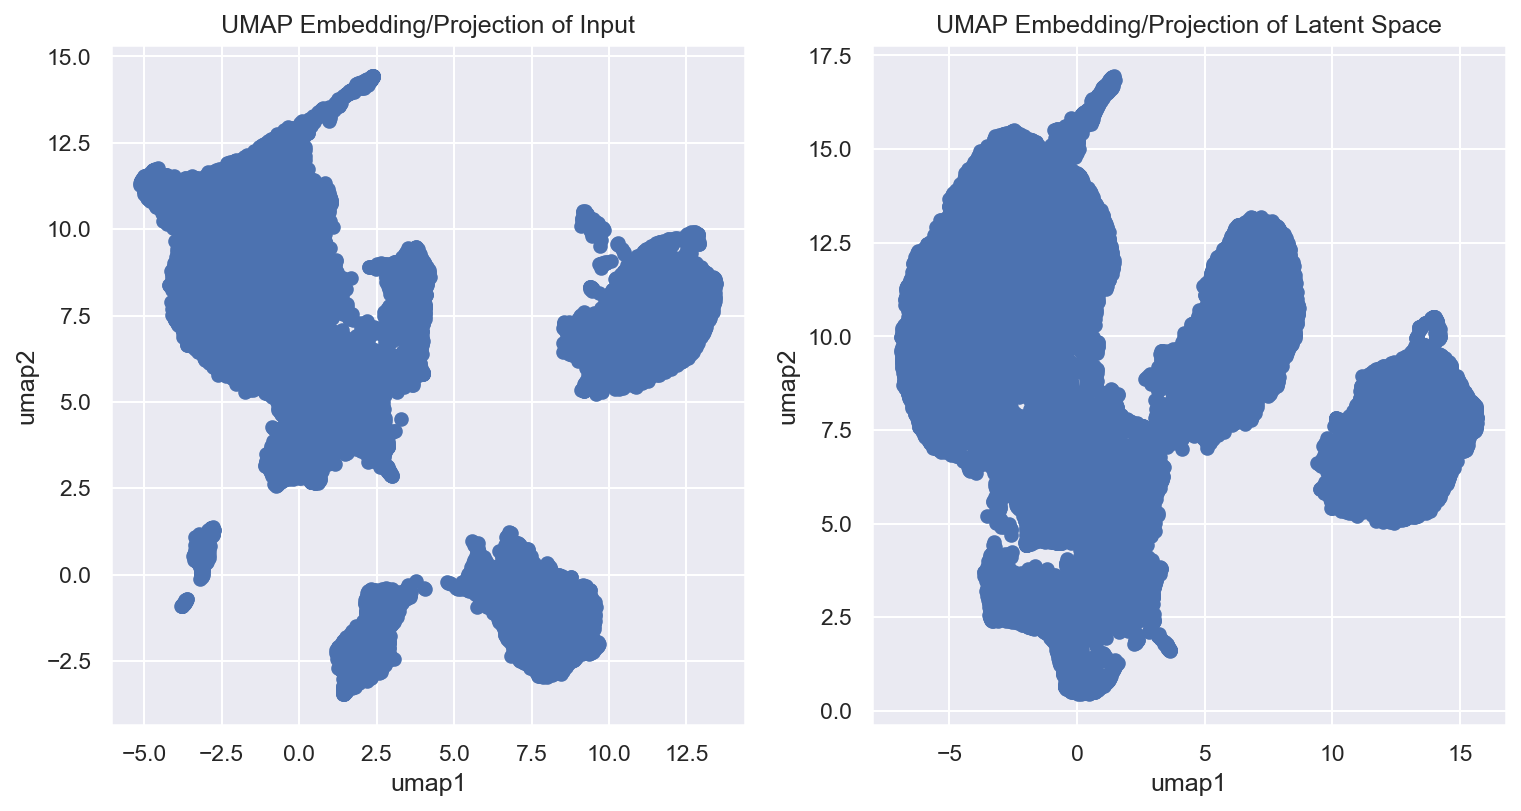

In [51]:
fit = umap.UMAP()
input_umap = fit.fit_transform(X_train)

fit = umap.UMAP()
z_mean, _, _ = vae.encoder.predict(X_train)
latent_umap = fit.fit_transform(z_mean)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6), dpi=150)
plt.subplots_adjust(wspace=0.2)

ax1.scatter(x=input_umap[:, 0], y=input_umap[:,1])
ax1.set_title("UMAP Embedding/Projection of Input")
ax1.set_xlabel("umap1")
ax1.set_ylabel("umap2")

ax2.scatter(x=latent_umap[:, 0], y=latent_umap[:,1])
ax2.set_title("UMAP Embedding/Projection of Latent Space")
ax2.set_xlabel("umap1")
ax2.set_ylabel("umap2")

plt.show()

## Make Some Predictions
Note that for the prediction we're using the `X_test` set that was not visibile to training, hence the model could not try to fit according to its data.

In [52]:
cell = X_test[0]
cell = cell.reshape(1, cell.shape[0])
mean, log_var, z = encoder.predict(cell)
encoded_cell = z
decoded_cell = decoder.predict(encoded_cell)
var_cell = vae.predict(cell)
print(f"Input shape:\t{cell.shape}")
print(f"Encoded shape:\t{encoded_cell.shape}")
print(f"Decoded shape:\t{decoded_cell.shape}")
print(f"\nInput:\n{cell[0]}")
print(f"\nEncoded:\n{encoded_cell[0]}")
print(f"\nDecoded:\n{decoded_cell[0]}")

Tensor("vae_2/decoder/dense_17/BiasAdd:0", shape=(None, 21), dtype=float32)
Input shape:	(1, 21)
Encoded shape:	(1, 6)
Decoded shape:	(1, 21)

Input:
[ 0.37931582  0.12237765 -1.29408803  0.71553804 -0.13310259  0.5478061
  1.35226966  0.12142522 -0.29417225 -0.03705264  0.11069364 -0.26496194
  0.92964366  0.77379775  0.88623151  1.06379237  1.61985055  2.30866301
 -0.03514568 -0.41097287 -0.52998523]

Encoded:
[-2.6863961 -4.456367  -2.82874   -2.5019693 -1.1505369  2.9448361]

Decoded:
[-0.01636571 -0.02752751 -0.1792907   0.29622915 -0.2736491   0.2026394
  0.34428266  0.3170801   0.17883864  0.25718755  0.0812577  -0.49226034
  1.3672422   1.2476432   1.2684354   1.2711946   1.3006228   1.2290365
 -0.17352466 -0.7126947  -0.16596897]


# Exploring the Latent Space

In [53]:
# Get all the possible permutations. For instance: 
# Input with three possible values for two latent 
# variables: 
# [[0.01 0.5  0.99], [0.01 0.5  0.99]]
# 
# All the possible combinations:
# [[[0.01 0.01], [0.5  0.01], [0.99 0.01]],
#  [[0.01 0.5 ], [0.5  0.5 ], [0.99 0.5 ]],
#  [[0.01 0.99], [0.5  0.99], [0.99 0.99]]]

# Linearly spaced latent variables.
# Values are transformed through the inverse CDF (PPF)
# of the Gaussian since the prior of the latent space
# is Gaussian.
step_size = 4
z = np.array([np.linspace(-4, 4, step_size)] * latent_dim)
#z = norm.ppf(z)

z_grid = np.dstack(np.meshgrid(*z))
z_grid = z_grid.reshape(step_size ** latent_dim, latent_dim)

x_pred_grid = decoder.predict(z_grid)
x_pred_grid = np.block(list(map(list, x_pred_grid)))

## Distribution of Latent Variables

Text(0, 0.5, 'Values')

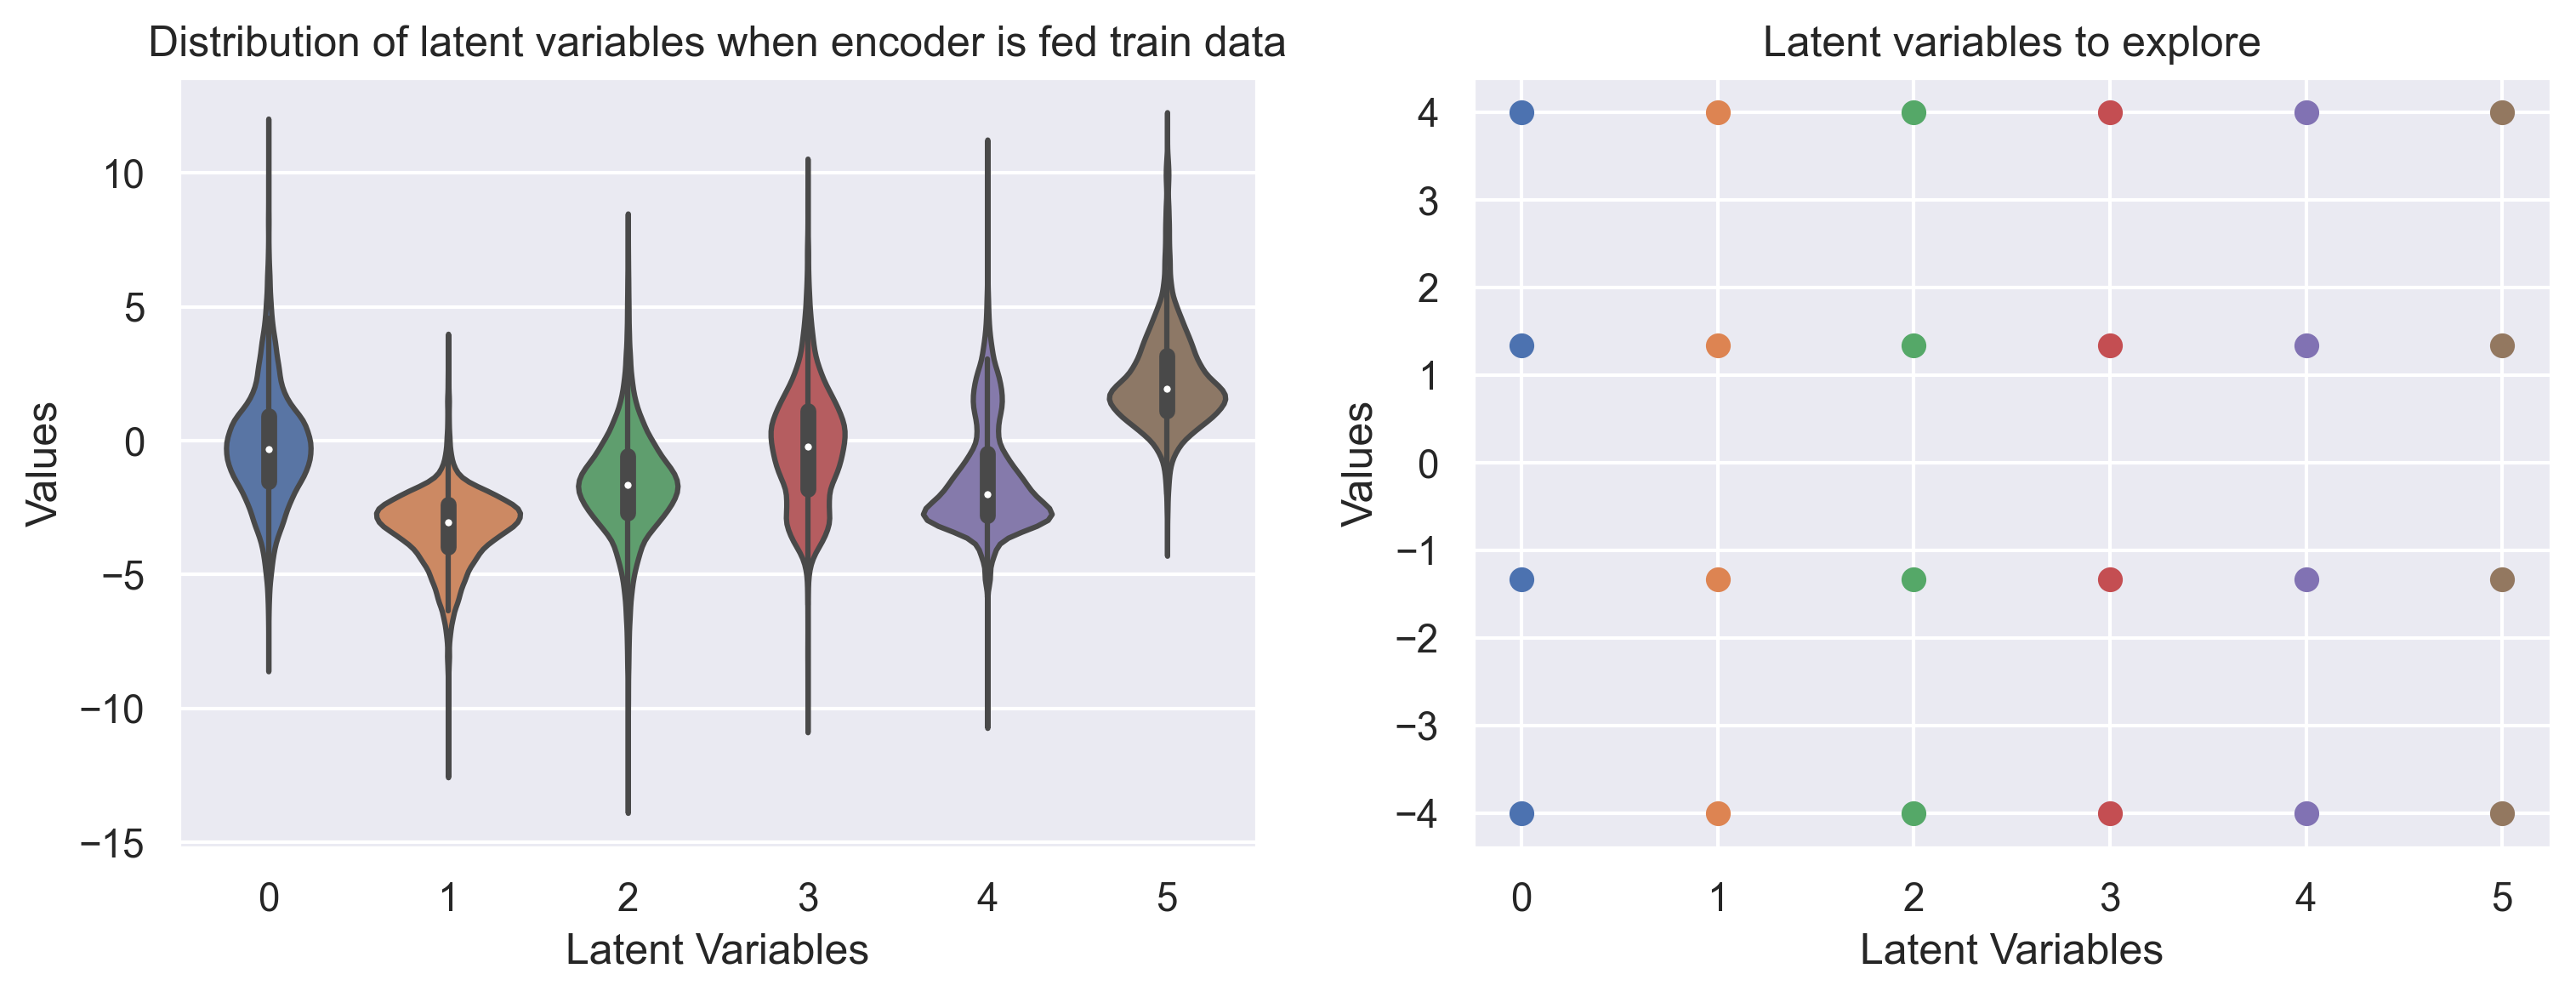

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4), dpi=300)
plt.subplots_adjust(wspace=0.2, hspace=0.1)

mean, log_var, latent_variables = encoder.predict(X_train)
sns.violinplot(data=latent_variables, ax=ax1)

## Two visualization options: 
## Option 1: show the distribution of z_grid 
## (a matrix of shape (4096, 6) depending on the variables set):
#sns.violinplot(data=z_grid, ax=ax2)
#
## Option 2: show the latent variables as in z (not the meshgrid, 
## which is matrix of shape (6, 4) depending on the variables set):
for i in range(latent_dim):
    x = [i] * step_size
    y = z[i, :]
    ax2.scatter(x, y)
ax1.set_title("Distribution of latent variables when encoder is fed train data")
ax1.set_xlabel("Latent Variables")
ax1.set_ylabel("Values")

ax2.set_title("Latent variables to explore")
ax2.set_xlabel("Latent Variables")
ax2.set_ylabel("Values")

In [ ]:
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 9), dpi=300, gridspec_kw={'width_ratios': [1, 5]})
plt.subplots_adjust(wspace=0.03, hspace=0.1)

sns.heatmap(z_grid, ax=ax1, cmap="YlGnBu", cbar_kws=dict(use_gridspec=False,location="top"))
sns.heatmap(x_pred_grid, ax=ax2, xticklabels=markers, yticklabels=False, cbar_kws=dict(use_gridspec=False,location="top", shrink=.25))

ax1.set_title("Latent Space")
ax1.set_ylabel("Combinations")

ax2.set_title("Reconstructed Marker Intensities")
ax2.set_xlabel("Marker")

Text(0.5, 237.25000000000003, 'Marker')

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 10), dpi=300, sharex=True)
sns.heatmap(X_train, ax=ax1, xticklabels=markers)
sns.heatmap(X_test,  ax=ax2, xticklabels=markers)
sns.heatmap(X_val,   ax=ax3, xticklabels=markers)

ax1.set_title("X Train")
ax2.set_title("X Test")
ax3.set_title("X Validation")
fig.tight_layout()

## Reconstructed Intensities
feed the encoder with the validation data, and plot the reconstructed intensities.

In [ ]:
recon_test = vae.predict(X_test)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9, 10), dpi=300, sharex=True)
sns.heatmap(X_test, ax=ax1, xticklabels=markers)
sns.heatmap(recon_test, ax=ax2, xticklabels=markers)

ax1.set_title("X Test")
ax2.set_title("Reconstructed X Test")
fig.tight_layout()